# DetKit Benchmark

This notebook plots the results that are produced by [``/benchmark/scripts/benchmark.py``](https://github.com/ameli/detkit/blob/main/benchmark/scripts/benchmark.py) script. The purpsoe of this script is to compare the presented method versus the conventional method of computing the determinant fnctions described below.

### Determinant Functions

The following functions are computed:

* **loggdet**: a determinant function used in Gaussian perocess (hence the name _log-gdet_).

$$
\begin{align}
\mathrm{loggdet}(\mathbf{A}, \mathbf{X}) :=& \mathrm{logdet}(\mathbf{A}) +  \mathrm{logdet}(\mathbf{X}^{\intercal} \mathbf{A}^{-1} \mathbf{X}) \tag{LD1}\\
=& \mathrm{logdet}(\mathbf{X}^{\intercal}  \mathbf{X}) + \mathrm{logdet}(\mathbf{N}) \tag{LD2}\\
=& \mathrm{logdet}(\mathbf{X}^{\intercal}  \mathbf{X}) + \mathrm{logdet}(\mathbf{U}_{\mathcal{X}^{\perp}}^{\intercal} \mathbf{A} \mathbf{U}_{\mathcal{X}^{\perp}}). \tag{LD3}
\end{align}
$$


where
* $\mathbf{N} = \mathbf{A} + \mathbf{P} - \mathbf{A}\mathbf{P}$
* $\mathbf{P} = \mathbf{I} - \mathbf{X}(\mathbf{X}^{\intercal} \mathbf{X})^{-1} \mathbf{X}$
* $\mathbf{M} = \mathbf{A}^{-1} - \mathbf{A}^{-1} \mathbf{X}(\mathbf{X}^{\intercal} \mathbf{A}^{-1} \mathbf{X})^{-1} \mathbf{X}^{\intercal} \mathbf{A}^{-1}$.
* $\mathbf{U}_{\mathcal{X}^{\perp}}$ is the orthonornal basis that is orthogonal to the image of $\mathbf{X}$.

For each of the above functions LD1, LD2, and LD3, we compute (1) the process time and (2) computational FLOPs.

### Input Data

* Matrix $\mathbf{A}$ is randmly generated symmetric and positive-definite (SPD) of the size $n = 2^9$. We *assume* both cases:
    * $\mathbf{A}$ is SPD.
    * $\mathbf{A}$ is not SPD.
    
* Matrix $\mathbf{X}$ is randomly generated with the size $n \times p$. The ratio $p/n$ is varried from $0, \cdots, 1$ at $t=50$ different ratios, while $n$ is fixed. The columns of this matrix are orthogonalized. We *assume* both cases:
    * $\mathbf{X}$ is orthogonal.
    * $\mathbf{X}$ is not orthogonal.
 

## Instructions to Reproduce Results

1. Compile the [`detkit`](http://www.github.com/ameli/detkit) package:

       ssh orbit
       cd ~/code
       git clone http://www.github.com/ameli/detkit
       cd detkit
       vim detkit/_definitions/definitions.h
       
   In [`/detkit/_definitions/definition.h`](https://github.com/ameli/detkit/blob/main/detkit/_definitions/definitions.h):
   
   * Set `PERF_COUNT` to `1` to enable counting FLOPs.
   * Set `CHUNK_TASKS` to `1`.
   * Set `USE_OPENMP` to `0`.
   
   **Compile the package twice** for each of (1) efficient Gramian matrix multiplication and (2) generic matrix multiplication:
   * To use symmetry in Gramian matrix multiplication, set `USE_SYMMETRY` to `1`
   * To not use symmetry in Gramian matrix multiplication, set `USE_SYMMETRY` to `0`.
   
   Then, compile with

       python setup.py install
       
2. Run a benchmark with $n = 2^9$, repeat the results for $r=10$ times, and each time, generate $t = 50$ data points in the interval for $p/n = 0, \cdots, 1$.

       cd benchmark/jobfiles
       vim jobfile_benchmark.pbs
       
   In [`/benchmark/jobfiles/jobfile_benchmark.pbs`](https://github.com/ameli/detkit/blob/main/benchmark/jobfiles/jobfile_benchmark.pbs), set `N=9` (corresponding to $n = 2^9$), `NUM_RATIOS=50` (corresponding to $t=50$), `REPEAT=10` (corresponding to $r=10$). Also, set `FUNC="loggdet"`, which computes $\mathrm{loggdet}(\mathbf{A}, \mathbf{X})$.
   
   Submit the job with
   
       qsub jobfile_benchmark.pbs
   
3. The pickle file results should be stored in [`/benchmark/pickle_results`](https://github.com/ameli/detkit/tree/main/benchmark/pickle_results). For the above two experiments, there should be two files with the names:
   
   | Output filename | function | matrix size | Gramian Matrix Multiplication  |
   | :-------------- | :------- | ----------- | :----------------------------- |
   | `benchmark_loggdet_9_gram.pickle` | $\mathrm{loggdet}$ | $n=2^9$ | with symmetry |
   | `benchmark_loggdet_9_no-gram.pickle` | $\mathrm{loggdet}$ | $n=2^9$ | without symmetry |
   
4. Run this notebook file, which it reads both of the the following files:

   | syntax | Gramian Matrix | Function |
   | :----- | :------------- | :------- |
   | `base_filename = 'benchmark-loggdet-9-gram`    | `USE_SYMMETRY=1` | `FUNC=loggdet` |
   | `base_filename = 'benchmark-loggdet-9-no-gram` | `USE_SYMMETRY=0` | `FUNC=loggdet` |
       
   For each of the above dataset, these plots are produced:
   
   * Process time and experimental FLOPs (from count of hardware instructions)
   * logdet values (either logpdet or loggdet). This plot will not be saved.
   
   and a following plot is produced independent of the pickle files:
   
   * Analytical FLOPs (from equation for the complexity of each oepration)
       
   The generated plots in the above will be saved in [`/benchmark/plots/svg`](https://github.com/ameli/detkit/tree/main/benchmark/plots/svg) and [`/benchmark/plots/pdf`](https://github.com/ameli/detkit/tree/main/benchmark/plots/pdf).
   
  
 ## Notes
 
 
 1. The FLOPs are computed using the count of _retired hardware instruction events_, using `perf` tool API in C++. This library can only use used on **Linux**, and only on **recent processors**.
 2. `CHUNK_TASKS` should be set to `1`. If it is set to `0`, first, the process times become very oscillatory, and second, the FLOPs per unit matrix-multiplicaiton task (`matmat` task) becomes a different number. For example, with chunk, the FLOP of `matmat` is near 5, and without it, it is 10.
 3. `USE_OPENMP` should be set to `0` to properly compare both methods of LHS and RHS.
 4. This code only uses one thread of a processor.

In [1]:
# Import packages
import numpy
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

import os
from os.path import join
import matplotlib
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import seaborn as sns
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{xfrac}'
#matplotlib.font_manager._rebuild()
sns.set(font_scale=1.15)
sns.set_style("white")
sns.set_style("ticks")
plt.rc('font', family='serif')
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
# Plot settings
benchmark_dir = '..'
subdir = '.'
fig_size = (5.6, 4.4)

# =========
# read data
# =========

def read_data(base_filename):
    """
    Read all data of a pickle file.
    """
    
    # Read file
    results_filename = join(benchmark_dir, 'pickle_results', subdir, base_filename + '.pickle')
    with open(results_filename, 'rb') as file:
        benchmark_results = pickle.load(file)
    results = benchmark_results['results']
    
    # Take mean of numerical experiment repetitions
    logdet_lgcy_gen_gen = results['logdet_lgcy_gen_gen'].mean(axis=1)
    logdet_lgcy_gen_ort = results['logdet_lgcy_gen_ort'].mean(axis=1)
    logdet_lgcy_spd_gen = results['logdet_lgcy_spd_gen'].mean(axis=1)
    logdet_lgcy_spd_ort = results['logdet_lgcy_spd_ort'].mean(axis=1)
    logdet_proj_gen = results['logdet_proj_gen'].mean(axis=1)
    logdet_proj_ort = results['logdet_proj_ort'].mean(axis=1)
    logdet_comp_gen_gen = results['logdet_comp_gen_gen'].mean(axis=1)
    logdet_comp_spd_gen = results['logdet_comp_spd_gen'].mean(axis=1)
    logdet_comp_gen_ort = results['logdet_comp_gen_ort'].mean(axis=1)
    logdet_comp_spd_ort = results['logdet_comp_spd_ort'].mean(axis=1)
    logdet_comp_gen_ort_xp = results['logdet_comp_gen_ort_xp'].mean(axis=1)
    logdet_comp_spd_ort_xp = results['logdet_comp_spd_ort_xp'].mean(axis=1)
    #logdet_comp_gen_ort_xp = 0
    #logdet_comp_spd_ort_xp = 0

    wall_time_lgcy_gen_gen = results['wall_time_lgcy_gen_gen'].mean(axis=1)
    wall_time_lgcy_gen_ort = results['wall_time_lgcy_gen_ort'].mean(axis=1)
    wall_time_lgcy_spd_gen = results['wall_time_lgcy_spd_gen'].mean(axis=1)
    wall_time_lgcy_spd_ort = results['wall_time_lgcy_spd_ort'].mean(axis=1)
    wall_time_proj_gen = results['wall_time_proj_gen'].mean(axis=1)
    wall_time_proj_ort = results['wall_time_proj_ort'].mean(axis=1)
    wall_time_comp_gen_gen = results['wall_time_comp_gen_gen'].mean(axis=1)
    wall_time_comp_spd_gen = results['wall_time_comp_spd_gen'].mean(axis=1)
    wall_time_comp_gen_ort = results['wall_time_comp_gen_ort'].mean(axis=1)
    wall_time_comp_spd_ort = results['wall_time_comp_spd_ort'].mean(axis=1)
    wall_time_comp_gen_ort_xp = results['wall_time_comp_gen_ort_xp'].mean(axis=1)
    wall_time_comp_spd_ort_xp = results['wall_time_comp_spd_ort_xp'].mean(axis=1)
    #wall_time_comp_gen_ort_xp = 0
    #wall_time_comp_spd_ort_xp = 0

    proc_time_lgcy_gen_gen = results['proc_time_lgcy_gen_gen'].mean(axis=1)
    proc_time_lgcy_gen_ort = results['proc_time_lgcy_gen_ort'].mean(axis=1)
    proc_time_lgcy_spd_gen = results['proc_time_lgcy_spd_gen'].mean(axis=1)
    proc_time_lgcy_spd_ort = results['proc_time_lgcy_spd_ort'].mean(axis=1)
    proc_time_proj_gen = results['proc_time_proj_gen'].mean(axis=1)
    proc_time_proj_ort = results['proc_time_proj_ort'].mean(axis=1)
    proc_time_proj_ort_pre = results['proc_time_proj_ort_pre'].mean(axis=1)
    proc_time_comp_gen_gen = results['proc_time_comp_gen_gen'].mean(axis=1)
    proc_time_comp_spd_gen = results['proc_time_comp_spd_gen'].mean(axis=1)
    proc_time_comp_gen_ort = results['proc_time_comp_gen_ort'].mean(axis=1)
    proc_time_comp_spd_ort = results['proc_time_comp_spd_ort'].mean(axis=1)
    proc_time_comp_gen_ort_xp = results['proc_time_comp_gen_ort_xp'].mean(axis=1)
    proc_time_comp_spd_ort_xp = results['proc_time_comp_spd_ort_xp'].mean(axis=1)
    #proc_time_comp_gen_ort_xp = 0
    #proc_time_comp_spd_ort_xp = 0

    flops_lgcy_gen_gen = results['flops_lgcy_gen_gen'].mean(axis=1)
    flops_lgcy_gen_ort = results['flops_lgcy_gen_ort'].mean(axis=1)
    flops_lgcy_spd_gen = results['flops_lgcy_spd_gen'].mean(axis=1)
    flops_lgcy_spd_ort = results['flops_lgcy_spd_ort'].mean(axis=1)
    flops_proj_gen = results['flops_proj_gen'].mean(axis=1)
    flops_proj_ort = results['flops_proj_ort'].mean(axis=1)
    flops_proj_ort_pre = results['flops_proj_ort_pre'].mean(axis=1)
    flops_comp_gen_gen = results['flops_comp_gen_gen'].mean(axis=1)
    flops_comp_spd_gen = results['flops_comp_spd_gen'].mean(axis=1)
    flops_comp_gen_ort = results['flops_comp_gen_ort'].mean(axis=1)
    flops_comp_spd_ort = results['flops_comp_spd_ort'].mean(axis=1)
    flops_comp_gen_ort_xp = results['flops_comp_gen_ort_xp'].mean(axis=1)
    flops_comp_spd_ort_xp = results['flops_comp_spd_ort_xp'].mean(axis=1)
    #flops_comp_gen_ort_xp = 0
    #flops_comp_spd_ort_xp = 0

    # Dicitionaries
    devices = benchmark_results['devices']
    config = benchmark_results['config']
    detkit_config = benchmark_results['detkit_config']
    ratios = config['ratios']
    
    # Print configurations
    print('Filename: %s\n' % results_filename)
    
    print('n:        %d' %config['n'])
    print('repeat:   %d' %config['repeat'])
    print('function: %s' %config['func'])

    print('')
    print('CPU:      %s' %devices['cpu_name'])
    print('num CPUs: %s' %devices['num_all_cpu_threads'])

    print('')
    print('use blas:     %s' % config['use_blas'])
    print('use_symmetry: %s' % detkit_config['use_symmetry'])
    print('use_openmp:   %s' % detkit_config['use_openmp'])
    print('chunk_tasks:  %s' % detkit_config['chunk_tasks'])
    print('count_perf:   %s' % detkit_config['count_perf'])

    print('')
    print('hw instructions per matmat:   %0.3f' % devices['instructions_per_matmat'])
    print('hw instructions per gramian:  %0.3f' % devices['instructions_per_gramian'])
    print('hw instructions per cholesky: %0.3f' % devices['instructions_per_cholesky'])
    print('hw instructions per lu:       %0.3f' % devices['instructions_per_lu'])
    print('hw instructions per lup:      %0.3f' % devices['instructions_per_lup'])
    print('-----------------------------------\n')
    
    # ================
    # 1. Legacy method, Sigma is not PSD, X is not orthogonal (in case of logpdet)
    # ================

    lgcy_gen_gen = {
        'logdet': logdet_lgcy_gen_gen,
        'wall_time': wall_time_lgcy_gen_gen,
        'proc_time': proc_time_lgcy_gen_gen,
        'flops': flops_lgcy_gen_gen,
        'color': r'gold',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LHS, $\mathbf{A}$ is not SPD',
        'order': 3,
    }

    if config['func'] == 'logpdet':
        lgcy_gen_gen['label'] += r', $\mathbf{X}$ is not orthogonal'

    # ================
    # 2. Legacy method, Sigma is not PSD, X is orthogonal (in case of logpdet)
    # ================

    lgcy_gen_ort = {
        'logdet': logdet_lgcy_gen_ort,
        'wall_time': wall_time_lgcy_gen_ort,
        'proc_time': proc_time_lgcy_gen_ort,
        'flops': flops_lgcy_gen_ort,
        'color': 'yellowgreen',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LHS, $\mathbf{A}$ is not SPD',
        'order': 3,
    }

    if config['func'] == 'loggdet':
        lgcy_gen_ort['logdet'] = lgcy_gen_gen['logdet']
        lgcy_gen_ort['wall_time'] = lgcy_gen_gen['wall_time']
        lgcy_gen_ort['proc_time'] = lgcy_gen_gen['proc_time']
        lgcy_gen_ort['flops'] = lgcy_gen_gen['flops']

    if config['func'] == 'logpdet':
        lgcy_gen_ort['label'] += r', $\mathbf{X}$ is orthogonal'

    # ================
    # 3. Legacy method, Sigma is PSD, X is not orthogonal (in case of logpdet)
    # ================

    lgcy_spd_gen = {
        'logdet': logdet_lgcy_spd_gen,
        'wall_time': wall_time_lgcy_spd_gen,
        'proc_time': proc_time_lgcy_spd_gen,
        'flops': flops_lgcy_spd_gen,
        'color': 'goldenrod',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LHS, $\mathbf{A}$ is SPD',
        'order': 3,
    }

    if config['func'] == 'logpdet':
        lgcy_spd_gen['label'] += r', $\mathbf{X}$ is not orthogonal'

    # ================
    # 4. Legacy method, Sigma is PSD, X is orthogonal (in case of logpdet)
    # ================

    lgcy_spd_ort = {
        'logdet': logdet_lgcy_spd_ort,
        'wall_time': wall_time_lgcy_spd_ort,
        'proc_time': proc_time_lgcy_spd_ort,
        'flops': flops_lgcy_spd_ort,
        'color': 'darkolivegreen',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LHS, $\mathbf{A}$ is SPD',
        'order': 3,
    }

    if config['func'] == 'loggdet':
        lgcy_spd_ort['logdet'] = lgcy_spd_gen['logdet']
        lgcy_spd_ort['wall_time'] = lgcy_spd_gen['wall_time']
        lgcy_spd_ort['proc_time'] = lgcy_spd_gen['proc_time']
        lgcy_spd_ort['flops'] = lgcy_spd_gen['flops']

    if config['func'] == 'logpdet':
        lgcy_spd_ort['label'] += r', $\mathbf{X}$ is orthogonal'

    # ====================
    # 5. Projection method, X is not orthogonal
    # ====================

    proj_gen = {
        'logdet': logdet_proj_gen,
        'wall_time': wall_time_proj_gen,
        'proc_time': proc_time_proj_gen,
        'flops': flops_proj_gen,
        'color': 'indianred',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'RHS, $\mathbf{X}$ is not orthogonal',
        'order': 3,
    }

    # ====================
    # 6. Projection method, X is orthogonal
    # ====================

    proj_ort = {
        'logdet': logdet_proj_ort,
        'wall_time': wall_time_proj_ort,
        'proc_time': proc_time_proj_ort,
        'flops': flops_proj_ort,
        'color': 'maroon',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'RHS, $\mathbf{X}$ is orthogonal',
        'order': 1,
    }

    # ====================
    # 7. Compression method, Sigma is not PSD, X is not Orthonormal
    # ====================

    comp_gen_gen = {
        'logdet': logdet_comp_gen_gen,
        'wall_time': wall_time_comp_gen_gen,
        'proc_time': proc_time_comp_gen_gen,
        'flops': flops_comp_gen_gen,
        'color': 'gold',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LD3, $\mathbf{A}$ is not SPD, $\mathbf{X}$ is not orthogonal',
        'order': 3,
    }

    # ====================
    # 8. Compression method, Sigma is PSD,  X is not Orthonormal
    # ====================

    comp_spd_gen = {
        'logdet': logdet_comp_spd_gen,
        'wall_time': wall_time_comp_spd_gen,
        'proc_time': proc_time_comp_spd_gen,
        'flops': flops_comp_spd_gen,
        'color': 'goldenrod',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LD3, $\mathbf{A}$ is SPD, $\mathbf{X}$ is not orthogonal',
        'order': 3,
    }

    # ====================
    # 9. Compression method, Sigma is not PSD, X is Orthonormal
    # ====================

    comp_gen_ort = {
        'logdet': logdet_comp_gen_ort,
        'wall_time': wall_time_comp_gen_ort,
        'proc_time': proc_time_comp_gen_ort,
        'flops': flops_comp_gen_ort,
        'color': 'cornflowerblue',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LD3, $\mathbf{A}$ is not SPD, $\mathbf{X}$ is orthogonal',
        'order': 3,
    }

    # ====================
    # 10. Compression method, Sigma is PSD,  X is Orthonormal
    # ====================

    comp_spd_ort = {
        'logdet': logdet_comp_spd_ort,
        'wall_time': wall_time_comp_spd_ort,
        'proc_time': proc_time_comp_spd_ort,
        'flops': flops_comp_spd_ort,
        'color': 'darkblue',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'full',
        'linestyle': '-',
        'label': r'LD3, $\mathbf{A}$ is SPD, $\mathbf{X}$ is orthogonal',
        'order': 3,
    }
    
    # ====================
    # 11. Compression method, Sigma is not PSD, X is Orthonormal, Xp is pre-computed
    # ====================

    comp_gen_ort_xp = {
        'logdet': logdet_comp_gen_ort_xp,
        'wall_time': wall_time_comp_gen_ort_xp,
        'proc_time': proc_time_comp_gen_ort_xp,
        'flops': flops_comp_gen_ort_xp,
        'color': 'cornflowerblue',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'none',
        'linestyle': ':',
        'label': r'LD3, $\mathbf{A}$ is not SPD, $\mathbf{X}$ is orthogonal, ' + \
                 r'$\mathbf{U}_{\mathcal{X}^{\perp}}$ is pre-computed',
        'order': 3,
    }

    # ====================
    # 12. Compression method, Sigma is PSD,  X is Orthonormal, Xp is pre-computed
    # ====================

    comp_spd_ort_xp = {
        'logdet': logdet_comp_spd_ort_xp,
        'wall_time': wall_time_comp_spd_ort_xp,
        'proc_time': proc_time_comp_spd_ort_xp,
        'flops': flops_comp_spd_ort_xp,
        'color': 'darkblue',
        'markersize': 6,
        'marker': '.',
        'fillstyle': 'none',
        'linestyle': ':',
        'label': r'LD3, $\mathbf{A}$ is SPD, $\mathbf{X}$ is orthogonal'  + \
                 r'$\mathbf{U}_{\mathcal{X}^{\perp}}$ is pre-computed',
        'order': 3,
    }
    
    # Save to dictionary
    workspace = {
        'devices': devices,
        'config': config,
        'detkit_config': detkit_config,
        'ratios': ratios,
        'lgcy_gen_gen': lgcy_gen_gen,
        'lgcy_gen_ort': lgcy_gen_ort,
        'lgcy_spd_gen': lgcy_spd_gen,
        'lgcy_spd_ort': lgcy_spd_ort,
        'proj_gen': proj_gen,
        'proj_ort': proj_ort,
        'comp_gen_gen': comp_gen_gen,
        'comp_spd_gen': comp_spd_gen,
        'comp_gen_ort': comp_gen_ort,
        'comp_spd_ort': comp_spd_ort,
        'comp_gen_ort_xp': comp_gen_ort_xp,
        'comp_spd_ort_xp': comp_spd_ort_xp
    }
    
    return workspace

# ========

# Choose one of the following four dataset
#base_filename = 'benchmark-loggdet-9-gram'
#base_filename = 'benchmark-logpdet-9-gram'
#base_filename = 'benchmark-loggdet-9-no-gram'
#base_filename = 'benchmark-logpdet-9-no-gram'

workspace_gram = read_data('benchmark-loggdet-9-gram')
workspace_no_gram = read_data('benchmark-loggdet-9-no-gram')

Filename: ../pickle_results/./benchmark-loggdet-9-gram.pickle

n:        512
repeat:   10
function: loggdet

CPU:      Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz
num CPUs: 20

use blas:     False
use_symmetry: True
use_openmp:   False
chunk_tasks:  True
count_perf:   True

hw instructions per matmat:   5.217
hw instructions per gramian:  2.601
hw instructions per cholesky: 1.322
hw instructions per lu:       4.996
hw instructions per lup:      3.657
-----------------------------------

Filename: ../pickle_results/./benchmark-loggdet-9-no-gram.pickle

n:        512
repeat:   10
function: loggdet

CPU:      Intel(R) Xeon(R) CPU E5-2680 v2 @ 2.80GHz
num CPUs: 20

use blas:     False
use_symmetry: False
use_openmp:   False
chunk_tasks:  False
count_perf:   True

hw instructions per matmat:   5.217
hw instructions per gramian:  5.219
hw instructions per cholesky: 1.322
hw instructions per lu:       4.996
hw instructions per lup:      3.657
-----------------------------------



In [3]:
# ===
# fit
# ===

def fit(x, y, order=1, num_outliers=0):
    """
    finds a in y = x**a. It recirsively removes the outlier with the largets error, with the total of
    "num_outliers" iterations.
    
    order determines the polynomial degree. In this work, order should be 1 for proj_ort data, and 3 for
    the rest of the data.
    """
    
    not_nan = numpy.logical_not(numpy.isnan(y))
    x = x[not_nan]
    y = y[not_nan]
    
    x_filt = numpy.copy(x)
    y_filt = numpy.copy(y)
    
    for i in range(num_outliers):
    
        coeff = numpy.polyfit(x_filt, y_filt, order)

        # Evaluate points using the model
        ym = numpy.polyval(coeff, x_filt)
        err = numpy.abs(y_filt - ym)

        err_indx = numpy.argsort(err)
        filt_indx = err_indx[:-1]

        # data without outliers
        x_filt = x_filt[filt_indx]
        y_filt = y_filt[filt_indx]
    
    coeff_filt = numpy.polyfit(x_filt, y_filt, order)
    
    # Interpolation
    #xi = numpy.linspace(x[0], x[-1])
    xi = numpy.linspace(0, 1)
    yi = numpy.polyval(coeff_filt, xi)
    
    return coeff_filt, xi, yi, x_filt, y_filt

# =======
# log fit
# =======

def log_fit(x, y, order=1):
    """
    finds a in y = x**a
    """
    
    not_nan = numpy.logical_not(numpy.isnan(y))
    x = x[not_nan]
    y = y[not_nan]
    
    log2_x = numpy.log2(x)
    log2_y = numpy.log2(y)
    
    coeff = numpy.polyfit(log2_x, log2_y, order)
    
    # Interpolation
    log2_xi = numpy.linspace(log2_x[0], log2_x[-1])
    log2_yi = numpy.polyval(coeff, log2_xi)
    
    xi = 2**(log2_xi)
    yi = 2**(log2_yi)
    
    return coeff, xi, yi

In [4]:
# =========
# save plot
# =========

def save_plot(
        plt,
        filename,
        transparent_background=True,
        pdf=True,
        bbox_extra_artists=None,
        verbose=False):
    """
    Saves plot as svg format in the current working directory.

    :param plt: matplotlib.pyplot object for the plots.
    :type plt: matplotlib.pyplot

    :param filename: Name of the file without extension or directory name.
    :type filename: string

    :param transparent_background: Sets the background of svg file to be
        transparent.
    :type transparent_background: bool
    """

    save_dir = join(benchmark_dir, 'plots')
    svg_save_dir = os.path.join(save_dir, 'svg')
    pdf_save_dir = os.path.join(save_dir, 'pdf')

    # Save plot in svg format
    filename_svg = filename + '.svg'
    filename_pdf = filename + '.pdf'
    save_fullname_svg = os.path.join(svg_save_dir, filename_svg)
    save_fullname_pdf = os.path.join(pdf_save_dir, filename_pdf)

    plt.savefig(
            save_fullname_svg,
            transparent=transparent_background,
            bbox_inches='tight')
    if verbose:
        print('Plot saved to "%s".' % (save_fullname_svg))

    if pdf:
        plt.savefig(
                save_fullname_pdf,
                transparent=transparent_background,
                bbox_extra_artists=bbox_extra_artists, bbox_inches='tight')
        if verbose:
            print('Plot saved to "%s".' % (save_fullname_pdf))

In [5]:
# ===============
# plot var helper
# ===============

def plot_var_helper(workspace, ax, data, title=None, variable='proc_time', ylim=None, num_outliers=0):
    """
    Plots a variable. variable can be eiher "proc_time" or "flops".
    """
    
    # Extract workspace
    ratios = workspace['ratios']
    config = workspace_gram['config']
    
    # Settings
    start = 1
    stride = 1
    plot_filtered = True
    millisecond = 1e+3
    
    for i in range(len(data)):
        
        var_ = data[i][variable]
        
        if variable in ['proc_time', 'wall_time']:
            var = var_ * millisecond
        elif variable == 'flops':
            var = var_ / (config['n']**3)
        else:
            var = var_
            
        markersize = data[i]['markersize']
        marker = data[i]['marker']
        linestyle = data[i]['linestyle']
        order = data[i]['order']
        color = data[i]['color']
        label = data[i]['label']
        fillstyle = data[i]['fillstyle']
        
        if num_outliers >= var.size:
            raise RuntimeError('"num_outliers" should be smaller than the data size.')
    
        coeff, xi, yi, ratios_filt, var_filt = fit(
            ratios[start:], var[start:], order=order, num_outliers=num_outliers)

        if plot_filtered:
            ratios_ = ratios_filt
            var_ = var_filt
        else:
            ratios_ = ratios
            var_ = var

        ax.plot(ratios_[start::stride], var_[start::stride], marker, color=color, markersize=markersize,
                fillstyle=fillstyle, label=label)

        if order == 1:
            fit_title = 'linear fit'
        elif order == 2:
            fit_title = 'quadratic fit'
        elif order == 3:
            fit_title = 'cubic fit'
        else:
            fit_title = 'curve fit'

        ax.plot(xi, yi, linestyle, color=color, markersize=markersize)

    ax.set_xlim([0, 1])
    ax.set_ylim(bottom=0, top=None)
    ax.set_xlabel(r'$p/n$')
    
    if variable == 'proc_time':
        ax.set_ylabel(r'Process Time (ms)')
    elif variable == 'wall_time':
        ax.set_ylabel(r'Elapsed Time (ms)')
    elif variable == 'flops':
        ax.set_ylabel(r'FLOPs/$n^3$')
        
    if title is not None:
        ax.set_title(title)
    ax.grid(axis='y')
    if ylim is not None:
        ax.set_ylim(ylim)

    plt.tight_layout()

# ========
# set ylim
# ========
    
def set_ylim(ax1, ax2):
    """
    Sets the ylim of two axes the same.
    """
    
    ymin_1, ymax_1 = ax1.get_ylim()
    ymin_2, ymax_2 = ax2.get_ylim()

    
    #ymin = numpy.min([ymin_1, ymin_2])
    #ymax = numpy.max([ymax_1, ymax_2])
    
    ymin = numpy.mean([ymin_1, ymin_2])
    ymax = numpy.mean([ymax_1, ymax_2])
    
    ax1.set_ylim([ymin, ymax])
    ax2.set_ylim([ymin, ymax])

In [6]:
# =================
# plot process time
# =================

def plot_processing_time(workspace, ax, num_outliers=5):
    """
    This function produces two different plots depending if the function is loggdet or logpdet.
    """

    # Extract workspace
    devices = workspace['devices']
    config = workspace['config']
    detkit_config = workspace['detkit_config']
    ratios = workspace['ratios']
    
    lgcy_gen_gen = workspace['lgcy_gen_gen']
    lgcy_gen_ort = workspace['lgcy_gen_ort']
    lgcy_spd_gen = workspace['lgcy_spd_gen']
    lgcy_spd_ort = workspace['lgcy_spd_ort']
    proj_gen = workspace['proj_gen']
    proj_ort = workspace['proj_ort']
    comp_gen_gen = workspace['comp_gen_gen']
    comp_spd_gen = workspace['comp_spd_gen']
    comp_gen_ort = workspace['comp_gen_ort']
    comp_spd_ort = workspace['comp_spd_ort']
    comp_gen_ort_xp = workspace['comp_gen_ort_xp']
    comp_spd_ort_xp = workspace['comp_spd_ort_xp']
    

    # Set ylim to be consistent over both use_symmetry=True and use_symmetry=False plots
    # The numbers below are only good for plots corresponding to the matrix size n=2**9.
    ylim = [0, 500]  # for logpdet
        

    # Two dfferent plots depending on loggdet or logpdet
    plot_var_helper(workspace, ax, [lgcy_gen_ort, lgcy_spd_ort, proj_gen, proj_ort, comp_gen_gen,
                                    comp_spd_gen, comp_gen_ort, comp_spd_ort, comp_gen_ort_xp,
                                    comp_spd_ort_xp],
                    title=None, variable='proc_time', ylim=ylim, num_outliers=num_outliers)

    # Title
    if detkit_config['use_symmetry']:
        title = r'(c) With symmetric matrix multiplication'
    else:
        title = r'(d) With full matrix multiplication'
    ax.set_title(title)

    
# ======================
# legend processing time
# ======================

def legend_processing_time(ax):
    """
    Legend for exp flops plot
    """
    
    # Legend
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    handles,labels = ax.get_legend_handles_labels()
    handles = [extra, handles[0], handles[1], handles[2], handles[3],
                      handles[4], handles[5], handles[6], handles[7],
               extra, extra, extra, extra, extra, extra, extra, handles[8], handles[9],
               extra, extra, extra, extra, extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra, extra, extra, extra, extra]
    labels = ["", "", "", "", "", "", "", "", "",
              "", "", "", "", "", "", "", "", "",
              r"\textbf{Func.}", "LD1", "LD1", "LD2", "LD2", "LD3", "LD3", "LD3", "LD3",
              r"\textbf{SPD}", "No", "Yes", r"---", "---", "No", "Yes", "No", "Yes",
              r"\textbf{Ortho.}", "---", "---", "No", "Yes", "No", "No", "Yes", "Yes"]
    #ax.legend(handles, labels, bbox_to_anchor=(0.0, 0.72), loc='upper left', ncol=4, handletextpad = -0.5,
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 1.025), loc='upper left', ncol=5, handletextpad = -0.5,
      columnspacing=-0.5, markerscale=1.5, fontsize='x-small')

In [7]:
# ==============
# plot exp flops
# ==============

def plot_exp_flops(workspace, ax, num_outliers=5):
    """
    Plots FLOPS from experimental analysis. FLOPs is computed using the retired hardware instructions events,
    divided by the same measure for a single taks in matrix-matrix multiplication.
    
    This function produces two different plots depending if the function is loggdet or logpdet.
    """
    
    # Extract workspace
    devices = workspace['devices']
    config = workspace['config']
    detkit_config = workspace['detkit_config']
    ratios = workspace['ratios']
    
    lgcy_gen_gen = workspace['lgcy_gen_gen']
    lgcy_gen_ort = workspace['lgcy_gen_ort']
    lgcy_spd_gen = workspace['lgcy_spd_gen']
    lgcy_spd_ort = workspace['lgcy_spd_ort']
    proj_gen = workspace['proj_gen']
    proj_ort = workspace['proj_ort']
    comp_gen_gen = workspace['comp_gen_gen']
    comp_spd_gen = workspace['comp_spd_gen']
    comp_gen_ort = workspace['comp_gen_ort']
    comp_spd_ort = workspace['comp_spd_ort']
    comp_gen_ort_xp = workspace['comp_gen_ort_xp']
    comp_spd_ort_xp = workspace['comp_spd_ort_xp']

    # Set ylim to be consistent over both use_symmetry=True and use_symmetry=False plots
    # The numbers below are only good for plots corresponding to the matrix size n=2**9.
    ylim = [0, 5]  # for logpdet

    # Two dfferent plots depending on loggdet or logpdet
    plot_var_helper(workspace, ax, [lgcy_gen_ort, lgcy_spd_ort, proj_gen, proj_ort, comp_gen_gen,
                                    comp_spd_gen, comp_gen_ort, comp_spd_ort, comp_gen_ort_xp,
                                    comp_spd_ort_xp],
                    title=None, variable='flops', ylim=ylim, num_outliers=num_outliers)
        
    # Title
    if detkit_config['use_symmetry']:
        title = r'(a) With symmetric matrix multiplication'
    else:
        title = r'(b) With full matrix multiplication'
    ax.set_title(title)
    
# ================
# legend exp flops
# ================

def legend_exp_flops(ax):
    """
    Legend for exp flops plot
    """
    
    # Legend
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    handles,labels = ax.get_legend_handles_labels()
    handles = [extra, handles[0], handles[1], handles[2], handles[3],
                      handles[4], handles[5], handles[6], handles[7],
               extra, extra, extra, extra, extra, extra, extra, handles[8], handles[9],
               extra, extra, extra, extra, extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra, extra, extra, extra, extra]
    labels = ["", "", "", "", "", "", "", "", "",
              "", "", "", "", "", "", "", "", "",
              r"\textbf{Func.}", "LD1", "LD1", "LD2", "LD2", "LD3", "LD3", "LD3", "LD3",
              r"\textbf{SPD}", "No", "Yes", r"---", "---", "No", "Yes", "No", "Yes",
              r"\textbf{Ortho.}", "---", "---", "No", "Yes", "No", "No", "Yes", "Yes"]
    #ax.legend(handles, labels, bbox_to_anchor=(1.0, 1.7), loc='upper left', ncol=4, handletextpad = -0.5,
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 1.025), loc='upper left', ncol=5, handletextpad = -0.5,
      columnspacing=-0.5, markerscale=1.5, fontsize='x-small')

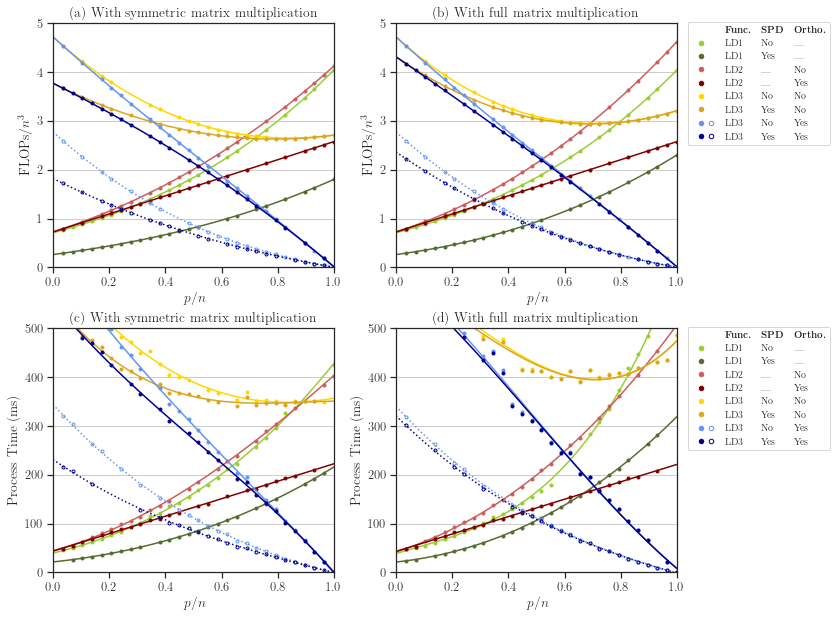

In [8]:
# Plot experimental flops and processing time

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11.84, 8.8))

plot_exp_flops(workspace_gram, ax[0, 0])
plot_exp_flops(workspace_no_gram, ax[0, 1])
legend_exp_flops(ax[0, 1])

plot_processing_time(workspace_gram, ax[1, 0])
plot_processing_time(workspace_no_gram, ax[1, 1])
legend_processing_time(ax[1, 1])

fig.tight_layout()
fig.subplots_adjust(hspace=0.25, wspace=0.22)

# Filename
config = workspace_gram['config']
str_n = str(int(numpy.log2(config['n'])))
filename = config['func'] + '-' + str_n + '-exp-flops-proc-time'

# Save
save_plot(plt, filename, transparent_background=True)

plt.show()

In [13]:
# ============================
# plot analytical flops helper
# ============================

def plot_analytical_flops_helper(workspace, ax, logpdet=0, flops_per_second=1, plot_orth=True, plot_psd=True,
                                 title=None):
    """
    To obtain the actual FLOPs, multiply by n**3. But since n is constant throuout the experiment,
    we plot flops per n**3.
    
    Scale adjusts the process time per flop.
    """
    
    # Extract workspace
    devices = workspace['devices']
    config = workspace['config']
    detkit_config = workspace['detkit_config']
    ratios = workspace['ratios']
    
    lgcy_gen_gen = workspace['lgcy_gen_gen']
    lgcy_gen_ort = workspace['lgcy_gen_ort']
    lgcy_spd_gen = workspace['lgcy_spd_gen']
    lgcy_spd_ort = workspace['lgcy_spd_ort']
    proj_gen = workspace['proj_gen']
    proj_ort = workspace['proj_ort']
    comp_gen_gen = workspace['comp_gen_gen']
    comp_spd_gen = workspace['comp_spd_gen']
    comp_gen_ort = workspace['comp_gen_ort']
    comp_spd_ort = workspace['comp_spd_ort']
    comp_gen_ort_xp = workspace['comp_gen_ort_xp']
    comp_spd_ort_xp = workspace['comp_spd_ort_xp']
    
    #n = config['n']
    #scale = n**3 * flops_per_second
    scale = flops_per_second

    # Variable of abscicssa, which is the ratio m/n. m is the num columns of X, and n is the size of A.
    r = numpy.linspace(0, 1)
    
    # Flops for each operation per n**3
    tr = 0.5        # solving triangular system (either of forward or backward substitution)
    mm = 1.0        # full matrix-matrix multiplication
    gr = 0.5        # Computating Gramian matrix multiplication takes half of generic matrix multiplication
    ch = 1.0/3.0    # cholesky decomposition
    lu = 2.0/3.0    # lu (or lup) decomposition
    gs = 2.0        # Gram-Schmidt
    ux = 0.0        # If the matrix U_{x_{\perp}} is precomputed, set this flag to zero, otherwise 1.

    # Complexity of each operation
    _lgcy_spd_gen_1    = scale * (ch +   tr*r + gr*mm*r**2 + ch*r**3 + logpdet*(gr*mm*r**2 + ch*r**3))
    _lgcy_spd_gen_2    = scale * (ch +   tr*r +    mm*r**2 + ch*r**3 + logpdet*(   mm*r**2 + ch*r**3))
    _lgcy_spd_ort_1    = scale * (ch +   tr*r + gr*mm*r**2 + ch*r**3)
    _lgcy_spd_ort_2    = scale * (ch +   tr*r +    mm*r**2 + ch*r**3)
    _lgcy_gen_gen_1    = scale * (lu + 2*tr*r +    mm*r**2 + lu*r**3 + logpdet*(gr*mm*r**2 + ch*r**3))
    _lgcy_gen_gen_2    = scale * (lu + 2*tr*r +    mm*r**2 + lu*r**3 + logpdet*(   mm*r**2 + ch*r**3))
    _lgcy_gen_ort      = scale * (lu + 2*tr*r +    mm*r**2 + lu*r**3)
    _proj_ort          = scale * (lu + 2*mm*r)
    _proj_gen_1        = scale * (lu + 2*mm*r + tr*r**2 + gr*mm*r**2 + ch*r**3)
    _proj_gen_2        = scale * (lu + 2*mm*r + tr*r**2 +    mm*r**2 + ch*r**3)
    _comp_gen_gen_1    = scale * (gs             + mm*(1-r) +    mm*(1-r)**2 + lu*(1-r)**3 + gr*mm*r**2 + ch*r**3)
    _comp_gen_gen_2    = scale * (gs             + mm*(1-r) +    mm*(1-r)**2 + lu*(1-r)**3 +    mm*r**2 + ch*r**3)
    _comp_spd_gen_1    = scale * (gs             + mm*(1-r) + gr*mm*(1-r)**2 + ch*(1-r)**3 + gr*mm*r**2 + ch*r**3)
    _comp_spd_gen_2    = scale * (gs             + mm*(1-r) +    mm*(1-r)**2 + ch*(1-r)**3 +    mm*r**2 + ch*r**3)
    _comp_gen_ort      = scale * (gs*(1-r**2)    + mm*(1-r) +    mm*(1-r)**2 + lu*(1-r)**3)
    _comp_spd_ort_1    = scale * (gs*(1-r**2)    + mm*(1-r) + gr*mm*(1-r)**2 + ch*(1-r)**3)
    _comp_spd_ort_2    = scale * (gs*(1-r**2)    + mm*(1-r) +    mm*(1-r)**2 + ch*(1-r)**3)
    _comp_gen_ort_xp   = scale * (gs*ux*(1-r**2) + mm*(1-r) +    mm*(1-r)**2 + lu*(1-r)**3)
    _comp_spd_ort_xp_1 = scale * (gs*ux*(1-r**2) + mm*(1-r) + gr*mm*(1-r)**2 + ch*(1-r)**3)
    _comp_spd_ort_xp_2 = scale * (gs*ux*(1-r**2) + mm*(1-r) +    mm*(1-r)**2 + ch*(1-r)**3)
    
    gram_linestyle = '-'
    full_linestyle = '--'
    xp_linestyle = ':'
    linewidth = 2
    
    # Plots
    if (not plot_psd or plot_psd is None) and (not plot_orth or plot_orth is None) and (logpdet != 0):
        ax.plot(r, _lgcy_gen_gen_1, gram_linestyle, linewidth=linewidth, color=lgcy_gen_gen['color'],
                label=lgcy_gen_gen['label'] + r', $\gamma = \sfrac{1}{2}$')  
        ax.plot(r, _lgcy_gen_gen_2, full_linestyle, linewidth=linewidth, color=lgcy_gen_gen['color'],
                label=lgcy_gen_gen['label'] + r', $\gamma = 1$')

    if (plot_psd or plot_psd is None) and (not plot_orth or plot_orth is None) and (logpdet != 0):
        ax.plot(r, _lgcy_spd_gen_1, gram_linestyle, linewidth=linewidth, color=lgcy_spd_gen['color'],
                label=lgcy_spd_gen['label'] + r', $\gamma = \sfrac{1}{2}$')
        ax.plot(r, _lgcy_spd_gen_2, full_linestyle, linewidth=linewidth, color=lgcy_spd_gen['color'],
                label=lgcy_spd_gen['label'] + r', $\gamma = 1$')
    
    if (not plot_psd or plot_psd is None) and (plot_orth or plot_orth is None):
        ax.plot(r, _lgcy_gen_ort, gram_linestyle, linewidth=linewidth, color=lgcy_gen_ort['color'],
                label=lgcy_gen_ort['label'])
        
    if (plot_psd or plot_psd is None) and (plot_orth or plot_orth is None):
        ax.plot(r, _lgcy_spd_ort_1, gram_linestyle, linewidth=linewidth, color=lgcy_spd_ort['color'],
                label=lgcy_spd_ort['label'] + r', $\gamma = \sfrac{1}{2}$')
        ax.plot(r, _lgcy_spd_ort_2, full_linestyle, linewidth=linewidth, color=lgcy_spd_ort['color'],
                label=lgcy_spd_ort['label'] + r', $\gamma = 1$')
        
    if (not plot_orth or plot_orth is None):
        ax.plot(r, _proj_gen_1, gram_linestyle, linewidth=linewidth, color=proj_gen['color'],
                label=proj_gen['label'] + ', $\gamma = \sfrac{1}{2}$')
        ax.plot(r, _proj_gen_2, full_linestyle, linewidth=linewidth, color=proj_gen['color'],
                label=proj_gen['label'] + ', $\gamma = 1$')
        
    if (plot_orth or plot_orth is None):
        ax.plot(r, _proj_ort, gram_linestyle, linewidth=linewidth, color=proj_ort['color'],
                label=proj_ort['label'])
        
    ax.plot(r, _comp_gen_gen_1, gram_linestyle, linewidth=linewidth, color=comp_gen_gen['color'],
            label=comp_gen_gen['label'])
    ax.plot(r, _comp_gen_gen_2, full_linestyle, linewidth=linewidth, color=comp_gen_gen['color'],
            label=comp_gen_gen['label'])
    ax.plot(r, _comp_spd_gen_1, gram_linestyle, linewidth=linewidth, color=comp_spd_gen['color'],
            label=comp_gen_gen['label'])
    ax.plot(r, _comp_spd_gen_2, full_linestyle, linewidth=linewidth, color=comp_spd_gen['color'],
            label=comp_gen_gen['label'])
    ax.plot(r, _comp_gen_ort, gram_linestyle, linewidth=linewidth, color=comp_gen_ort['color'],
            label=comp_gen_ort['label'])
    ax.plot(r, _comp_spd_ort_1, gram_linestyle, linewidth=linewidth, color=comp_spd_ort['color'],
            label=comp_gen_ort['label'])
    ax.plot(r, _comp_spd_ort_2, full_linestyle, linewidth=linewidth, color=comp_spd_ort['color'],
            label=comp_gen_ort['label'])
    ax.plot(r, _comp_gen_ort_xp, xp_linestyle, linewidth=linewidth, color=comp_gen_ort_xp['color'],
            label=comp_gen_ort_xp['label'])
    ax.plot(r, _comp_spd_ort_xp_1, xp_linestyle, linewidth=linewidth, color=comp_spd_ort_xp['color'],
            label=comp_gen_ort_xp['label'])
    ax.plot(r, _comp_spd_ort_xp_2, xp_linestyle, linewidth=linewidth, color=comp_spd_ort_xp['color'],
            label=comp_gen_ort_xp['label'])
    
    # Annotations
    ax.set_xlim([0, 1])
    #ax.set_ylim(bottom=0, top=None)
    ax.set_ylim(bottom=0, top=5)
    ax.set_xlabel(r'$p/n$')
    ax.set_ylabel(r'Complexity / $n^3$')
    #if title is not None:
    #    ax.set_title(title)
    ax.grid(axis='y')
    ax.legend(fontsize='x-small')
    
    plt.tight_layout()

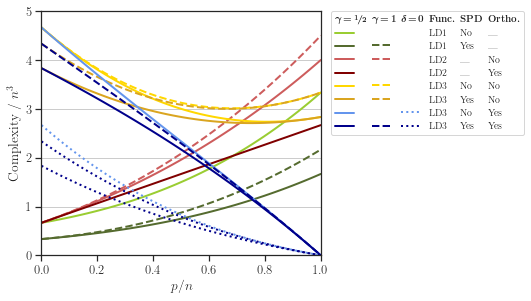

In [14]:
# =====================
# plot analytical flops
# =====================

def plot_analytical_flops(workspace):
    """
    Plots analytical FLOPs using the relations for the complexity of loggdet or logpdet. The FLOPs here
    are defined as one multiplication and one addition together. The experimental FLOPs (see the above 
    function) is expected to match the analytical FLOPs (this function). 
    
    This plot combines both cases where the Gramian matrix multiplication is performed using the symmetry
    of the matrix (solid lines, gamma = 1/2) and without it (dashes lines, gamma=1).
    
    This function produces two different plots depending if the function is loggdet or logpdet.
    """

    #fig, ax = plt.subplots(figsize=(5.5*2, 4.4*3), ncols=2, nrows=3)
    #fig, ax = plt.subplots(figsize=fig_size)
    fig, ax = plt.subplots(figsize=(5, 4.4))

    #plot_flops(ax[0][0], logpdet=1, plot_psd=False,  plot_orth=None,
    #           title=r'(a) $\mathbf{A}$ is not PSD')
    #plot_flops(ax[0][1], logpdet=1, plot_psd=True, plot_orth=None,
    #           title=r'(b) $\mathbf{A}$ is not PSD')
    #plot_flops(ax[1][0], logpdet=1, plot_psd=None,  plot_orth=False,
    #           title=r'(a) $\mathbf{X}$ is not orthogonal')
    #plot_flops(ax[1][1], logpdet=1, plot_psd=None, plot_orth=True,
    #           title=r'(b) $\mathbf{X}$ is orthogonal')

    if config['func'] == 'loggdet':
        logpdet = 0
    elif config['func'] == 'logpdet':
        logpdet = 1

    # Two dfferent plots depending on loggdet or logpdet
    if config['func'] == 'loggdet':
        title = '(b) $\operatorname{logdet}(\mathbf{A}, \mathbf{X})$'
    elif config['func'] == 'logpdet':
        title = r'(a) $\operatorname{logpdet}(\mathbf{M})$'
    plot_analytical_flops_helper(workspace, ax, logpdet=logpdet, plot_psd=None, plot_orth=None, title=title)
    
    # Legend
    extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    handles,labels = ax.get_legend_handles_labels()
    handles = [extra, handles[0], handles[1], handles[3], handles[5], 
                      handles[6], handles[8], handles[10], handles[11],
               extra, extra, handles[2], handles[4], extra, handles[7],
                      handles[9], extra, handles[12],
               extra, extra, extra, extra, extra, extra, extra, handles[13], handles[14],
               extra, extra, extra, extra, extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra, extra, extra, extra, extra,
               extra, extra, extra, extra, extra, extra, extra, extra, extra]
    labels = [r"$\boldsymbol{\gamma\!=\!\sfrac{1}{2}}$", "", "", "", "", "", "", "", "",
              r"$\boldsymbol{\gamma\!=\!1}$", "", "", "", "", "", "", "", "",
              r"$\boldsymbol{\delta\!=\!0}$", "", "", "", "", "", "", "", "",
              r"\textbf{Func.}", "LD1", "LD1", "LD2", "LD2", "LD3", "LD3", "LD3", "LD3",
              r"\textbf{SPD}", "No", "Yes", "---", "---", "No", "Yes", "No", "Yes",
              r"\textbf{Ortho.}", "---", "---", "No", "Yes", "No", "No", "Yes", "Yes"]
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 1.02), loc='upper left', ncol=6, handletextpad = -2,
      columnspacing=0.5, fontsize='x-small', handlelength=2)
        
    # Test
    #a = numpy.linspace(0, 1)
    #gamma=1.0/2
    #f_1 = (1.0/3)*a**3 + gamma*a**2 + (1-a)**2 + (1-a) + (1.0/3)*(1-a)**3 + 2.0/3
    #gamma=1.0
    #f_2 = (1.0/3)*a**3 + gamma*a**2 + (1-a)**2 + (1-a) + (1.0/3)*(1-a)**3 + 2.0/3
    #ax.plot(a, f_1, color='black')
    #ax.plot(a, f_2, '--', color='black')
        

    # filename
    str_n = str(int(numpy.log2(config['n'])))
    filename = config['func'] + '-' + str_n + '-analytic-flops'

    # Save
    save_plot(plt, filename, transparent_background=True)
    #fig.tight_layout()

    plt.show()
    
# =====

plot_analytical_flops(workspace_gram)

In [11]:
# ==================
# plot logdet helper
# ==================

def plot_logdet_helper(workspace, ax, data, start=0):
    """
    Plots either loggdet or logpdet.
    """
    
    # Extract workspace
    devices = workspace['devices']
    config = workspace['config']
    detkit_config = workspace['detkit_config']
    ratios = workspace['ratios']
    
    for i in range(len(data)):
        logdet = data[i]['logdet']
        markersize = data[i]['markersize']
        marker = data[i]['marker']
        linestyle = data[i]['linestyle']
        order = data[i]['order']
        color = data[i]['color']
        label = data[i]['label']

        ax.plot(ratios[start:], logdet[start:], color=color, markersize=markersize, label=label)

    ax.set_xlim([0, 1])
    ax.set_xlabel(r'$p/n$')
    ax.set_ylabel(config['func'])
    ax.legend(fontsize='x-small')
    ax.grid(axis='y')
    
    # Title
    if detkit_config['use_symmetry']:
        title = r'(a) With symmetric matrix multiplication'
    else:
        title = r'(b) With full matrix multiplication'
    ax.set_title(title)

    plt.tight_layout()

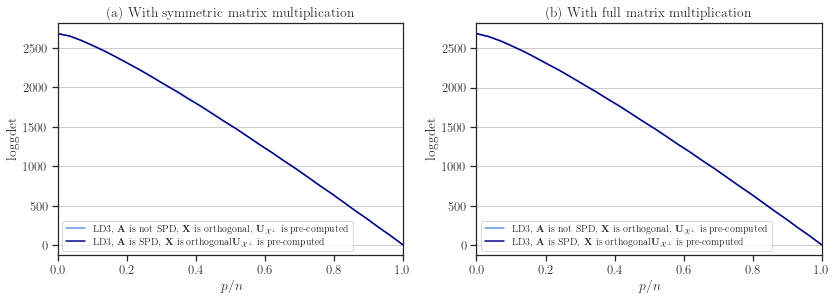

In [12]:
# ===========
# plot logdet
# ===========

def plot_logdet(workspace, ax):
    """
    Plots either loggdet or logpdet.
    
    This plot is not used in the publication. The purpose of this plot is to check of the computations were
    performed correctly. That is, all 6 curves in this plot should overlap excatly on each other.
    """
    
    # Extract workspace
    devices = workspace['devices']
    config = workspace['config']
    detkit_config = workspace['detkit_config']
    ratios = workspace['ratios']
    
    lgcy_gen_gen = workspace['lgcy_gen_gen']
    lgcy_gen_ort = workspace['lgcy_gen_ort']
    lgcy_spd_gen = workspace['lgcy_spd_gen']
    lgcy_spd_ort = workspace['lgcy_spd_ort']
    proj_gen = workspace['proj_gen']
    proj_ort = workspace['proj_ort']
    comp_gen_gen = workspace['comp_gen_gen']
    comp_spd_gen = workspace['comp_spd_gen']
    comp_gen_ort = workspace['comp_gen_ort']
    comp_spd_ort = workspace['comp_spd_ort']
    comp_gen_ort_xp = workspace['comp_gen_ort_xp']
    comp_spd_ort_xp = workspace['comp_spd_ort_xp']

    #plot_logdet_helper(workspace, ax, [lgcy_gen_gen, lgcy_spd_gen, proj_gen, proj_ort, comp_gen_gen, 
    #                                   comp_spd_gen, comp_gen_ort, comp_spd_ort, comp_gen_ort_xp,
    #                                   comp_spd_ort_xp])
    plot_logdet_helper(workspace, ax, [comp_gen_ort_xp,
                                       comp_spd_ort_xp])

# =====

fig, ax = plt.subplots(ncols=2, figsize=(11.84, 4.4))

plot_logdet(workspace_gram, ax[0])
plot_logdet(workspace_no_gram, ax[1])
                                       
# Filename
config = workspace_gram['config']
str_n = str(int(numpy.log2(config['n'])))
filename = config['func'] + '-' + str_n + '-func-value'

# Save
#save_plot(plt, filename, transparent_background=True)
#ax.set_title('Computing Log-Determinants of Posterior Function')
                                       
fig.tight_layout()
plt.show()